In [330]:
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np 
import pandas as pd 
import os 

### Reading all the files 

In [7]:
directory = 'data/Sales Data/'
def read_multiple_tables(directory):
    df = pd.DataFrame()
    for folder in os.listdir(directory):
        if folder not in ['.DS_Store', '.ipynb_checkpoints']:
            for file in os.listdir(os.path.join(directory , folder)):
                if file != '.ipynb_checkpoints':
                    files_dir = os.path.join(directory , folder , file)
                    df_1 = pd.read_excel(files_dir, engine='pyxlsb')
                df = pd.concat([df , df_1] , axis = 0)
    return df



##### Now we have the data for past 5 years so we need the data for the dealers who are active for all the months but before that the data need to be in the datetime format.

In [16]:
import datetime
def timeseries_conversion(excel_serial_number):
    reference_date = datetime.datetime(1900, 1, 1)
    dt = reference_date + datetime.timedelta(days=excel_serial_number - 2)
    return dt

In [17]:
df['Billing Date'] = df['Billing Date'].apply(timeseries_conversion)

In [21]:
from utils.datetime_util import create_date_columns
df_sales = create_date_columns([df])

##### Now the table is in required format. We need to check for the following trends. 
1. Seasonal dealers
2. Dealer to Sub Dealer conversion

### Selecting the variables of our concern

In [22]:
df_sales.columns

Index(['Month', 'Billing Date', 'Sales Region', 'Sales Zone', 'Sales Type',
       'Manufacturing Plant', 'Manufacturing Plant Name', 'Plant',
       'Plant Name', 'Sold To Party Code', 'Sold to Party Name',
       'Sold To Party District Name', 'Ship to Party Code',
       'Ship to Party Name', 'Ship to Party District', 'Invoice no',
       'Direct Depot', 'Incoterms_INCO1', 'Mode of Transport', 'T Zone',
       'T Zone Desc', 'Brand', 'Product', 'Bill Quantity', 'Gross Bill Price',
       'Zbill_Invoice_bill', 'Tzone Desc.', 'diff',
       'Sold To Party District Name.1', 'Net Bill Price', 'date', 'Month_Year',
       'Year', 'Quarter'],
      dtype='object')

In [66]:
important_cols = ['Sales Region', 'Sales Zone', 'Sales Type',
        'Sold To Party Code', 'Sold To Party District Name', 'Ship to Party Code',
        'Ship to Party District', 'Brand', 'Product', 'Bill Quantity', 'date', 'Month_Year',
       'Year', 'Quarter']

In [67]:
df_sales_new = df_sales[important_cols]

In [68]:
df_sales_new.head()

,Sales Region,Sales Zone,Sales Type,Sold To Party Code,Sold To Party District Name,Ship to Party Code,Ship to Party District,Brand,Product,Bill Quantity,date,Month_Year,Year,Quarter
0,South,Goa,Trade,7031240,North Goa,77074837,NORTH GOA,DALMIA,OPC,13.0,2021-07-01,2021-07,2021,2021Q3
1,South,Goa,Trade,7015228,South Goa,88005773,NORTH GOA,DALMIA,PPC,13.0,2021-07-03,2021-07,2021,2021Q3
2,South,Goa,Trade,7015228,South Goa,77073771,NORTH GOA,DALMIA,PPC,26.0,2021-07-03,2021-07,2021,2021Q3
3,South,Goa,Trade,7031479,South Goa,7031479,SOUTH GOA,DALMIA,PPC,13.0,2021-07-06,2021-07,2021,2021Q3
4,South,Goa,Trade,7031240,North Goa,88018025,SOUTH GOA,DALMIA,PPC,13.0,2021-07-06,2021-07,2021,2021Q3


In [69]:
df_sales_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10983388 entries, 0 to 137618
Data columns (total 14 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   Sales Region                 object        
 1   Sales Zone                   object        
 2   Sales Type                   object        
 3   Sold To Party Code           object        
 4   Sold To Party District Name  object        
 5   Ship to Party Code           object        
 6   Ship to Party District       object        
 7   Brand                        object        
 8   Product                      object        
 9   Bill Quantity                float64       
 10  date                         datetime64[ns]
 11  Month_Year                   object        
 12  Year                         int64         
 13  Quarter                      period[Q-DEC] 
dtypes: datetime64[ns](1), float64(1), int64(1), object(10), period[Q-DEC](1)
memory usage: 1.2+ GB


In [70]:
df_sales_new['Sales Type'].value_counts()

Trade            9172275
Institutional    1794867
Export Sales       16246
Name: Sales Type, dtype: int64

In [71]:
df_sales_new[df_sales_new['Sales Type']=='Trade']['Sold To Party Code'].min()

200078

In [72]:
#selecting only dealers
df_sales_new['Sold To Party Code'] = df_sales_new['Sold To Party Code'].astype('uint8')

ValueError: invalid literal for int() with base 10: 'DONATION'

##### There are String in the sold to party code, so need to remove the same and work on the same 

In [73]:
doantion = df_sales_new[df_sales_new['Sold To Party Code']=='DONATION']
df_sales_new =df_sales_new[df_sales_new['Sold To Party Code']!='DONATION']

In [74]:
df_sales_new['Sold To Party Code'] = df_sales_new['Sold To Party Code'].astype(int)

In [75]:
df_sales_new.head()

,Sales Region,Sales Zone,Sales Type,Sold To Party Code,Sold To Party District Name,Ship to Party Code,Ship to Party District,Brand,Product,Bill Quantity,date,Month_Year,Year,Quarter
0,South,Goa,Trade,7031240,North Goa,77074837,NORTH GOA,DALMIA,OPC,13.0,2021-07-01,2021-07,2021,2021Q3
1,South,Goa,Trade,7015228,South Goa,88005773,NORTH GOA,DALMIA,PPC,13.0,2021-07-03,2021-07,2021,2021Q3
2,South,Goa,Trade,7015228,South Goa,77073771,NORTH GOA,DALMIA,PPC,26.0,2021-07-03,2021-07,2021,2021Q3
3,South,Goa,Trade,7031479,South Goa,7031479,SOUTH GOA,DALMIA,PPC,13.0,2021-07-06,2021-07,2021,2021Q3
4,South,Goa,Trade,7031240,North Goa,88018025,SOUTH GOA,DALMIA,PPC,13.0,2021-07-06,2021-07,2021,2021Q3


In [81]:
#selecting only dealers from the dataframe
df_sales_new = df_sales_new[(df_sales_new['Sold To Party Code']>=7000000)&(df_sales_new['Sold To Party Code']<7100000)]

In [82]:
df_sales_new['Sold To Party Code'].min()

7000001

In [83]:
df_sales_new

,Sales Region,Sales Zone,Sales Type,Sold To Party Code,Sold To Party District Name,Ship to Party Code,Ship to Party District,Brand,Product,Bill Quantity,date,Month_Year,Year,Quarter
0,South,Goa,Trade,7031240,North Goa,77074837,NORTH GOA,DALMIA,OPC,13.0,2021-07-01,2021-07,2021,2021Q3
1,South,Goa,Trade,7015228,South Goa,88005773,NORTH GOA,DALMIA,PPC,13.0,2021-07-03,2021-07,2021,2021Q3
2,South,Goa,Trade,7015228,South Goa,77073771,NORTH GOA,DALMIA,PPC,26.0,2021-07-03,2021-07,2021,2021Q3
3,South,Goa,Trade,7031479,South Goa,7031479,SOUTH GOA,DALMIA,PPC,13.0,2021-07-06,2021-07,2021,2021Q3
4,South,Goa,Trade,7031240,North Goa,88018025,SOUTH GOA,DALMIA,PPC,13.0,2021-07-06,2021-07,2021,2021Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137487,NE,Manipur,Trade,7008811,IMPHAL,77026543,IMPHAL WEST,DALMIA,PPC,17.5,2019-07-31,2019-07,2019,2019Q3
137488,NE,Manipur,Trade,7008811,MOIRANG,77027921,Bishnupur,DALMIA,PPC,21.0,2019-07-31,2019-07,2019,2019Q3
137489,NE,Manipur,Trade,7008811,THOUBAL,77044984,THOUBAL,DALMIA,PPC,21.0,2019-07-31,2019-07,2019,2019Q3
137490,NE,Manipur,Trade,7008811,THOUBAL,77044984,THOUBAL,DALMIA,PPC,20.0,2019-07-31,2019-07,2019,2019Q3


In [331]:
df_sales_new = df_sales_new[df_sales_new['date']>='2021-04-01']

In [332]:
df_sales_new

,Sales Region,Sales Zone,Sales Type,Sold To Party Code,Sold To Party District Name,Ship to Party Code,Ship to Party District,Brand,Product,Bill Quantity,date,Month_Year,Year,Quarter
0,South,Goa,Trade,7031240,North Goa,77074837,NORTH GOA,DALMIA,OPC,13.0,2021-07-01,2021-07,2021,2021Q3
1,South,Goa,Trade,7015228,South Goa,88005773,NORTH GOA,DALMIA,PPC,13.0,2021-07-03,2021-07,2021,2021Q3
2,South,Goa,Trade,7015228,South Goa,77073771,NORTH GOA,DALMIA,PPC,26.0,2021-07-03,2021-07,2021,2021Q3
3,South,Goa,Trade,7031479,South Goa,7031479,SOUTH GOA,DALMIA,PPC,13.0,2021-07-06,2021-07,2021,2021Q3
4,South,Goa,Trade,7031240,North Goa,88018025,SOUTH GOA,DALMIA,PPC,13.0,2021-07-06,2021-07,2021,2021Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190497,West,MH (W),Trade,7036014,Jalgaon,7036014,JALGAON,DALMIA,PPC,7.5,2022-07-31,2022-07,2022,2022Q3
190498,West,MH (W),Trade,7036014,Jalgaon,7036014,JALGAON,DALMIA,PPC,0.0,2022-07-31,2022-07,2022,2022Q3
190499,West,MH (W),Trade,7036014,Jalgaon,7036014,JALGAON,DALMIA,PPC,0.0,2022-07-31,2022-07,2022,2022Q3
190500,West,MH (W),Trade,7036014,Jalgaon,7036014,JALGAON,DALMIA,PPC,0.0,2022-07-31,2022-07,2022,2022Q3


In [333]:
df_group_dealer= df_sales_new[['Sold To Party Code','Sales Zone']].groupby([ 'Sold To Party Code','Sold To Party District Name']).agg({'Sold To Party District Name': ['count']}).reset_index()

KeyError: 'Sold To Party District Name'

In [329]:
df_group_dealer

Sold To Party Code Sold To Party District Name      
                                                     count
0                7000001                  GODIJHARIA    11
1                7000002                       JALDA   476
2                7000002                  SUNDARGARH    57
3                7000004                     ANNAPAL   167
4                7000004                     BHADRAK   669
...                  ...                         ...   ...
32692            7039320                   BEGUSARAI     1
32693            7039324                   SAMBALPUR     1
32694            7039325                     Vellore     3
32695            7039333                    Kolhapur     1
32696            7039348                       BUXAR     3

[32697 rows x 3 columns]

##### Grouping each Dealer based on the month year and then analyze the seasonality month wise 

In [334]:
df_group_month = df_sales_new[['Sold To Party Code','Month_Year',
                     'Bill Quantity']].groupby(['Sold To Party Code',
                                                'Month_Year']).agg({'Bill Quantity': ['sum']}).reset_index()

In [335]:
df_group_month.columns = ['Sold To Party Code', 'Month Year' , 'Sum']

In [336]:
df_group_month

,Sold To Party Code,Month Year,Sum
0,7000004,2021-04,255.50
1,7000004,2021-05,85.00
2,7000004,2021-06,207.00
3,7000004,2021-07,102.00
4,7000004,2021-08,73.50
...,...,...,...
195600,7039320,2023-02,20.00
195601,7039324,2023-02,25.00
195602,7039325,2023-02,15.00
195603,7039333,2023-02,5.00


In [337]:
pivot_table = pd.pivot_table(df_group_month, values='Sum',
                       columns='Month Year', index = 'Sold To Party Code')

In [338]:
pivot_table

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,114.0,35.0,22.0,40.0,20.0,20.0,20.0,122.5,75.0,90.00
7000010,57.0,37.0,NaN,24.0,30.0,NaN,41.0,24.0,25.0,24.0,...,17.0,NaN,33.8,24.0,NaN,NaN,NaN,NaN,NaN,NaN
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,75.5,85.0,42.0,109.0,45.0,74.0,27.0,NaN,NaN,NaN
7000019,12.0,50.0,133.0,104.0,165.0,123.5,NaN,7.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7000022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.5,1.5,12.0,24.0,24.0,22.0,5.0,21.0,24.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.00
7039324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.00
7039325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.00


In [339]:
pivot_copy = pivot_table.copy()

In [125]:
def churn_data(pivot_table):
    rows_with_consecutive_nan = []

    for _, row in pivot_table.iterrows():
        nan_count = 0
        for value in row:
            if pd.isna(value):
                nan_count += 1
                if nan_count >3 and nan_count<=12:
                    rows_with_consecutive_nan.append('Inactive_atleast_once')
                    break
                if nan_count>12:
                    rows_with_consecutive_nan.append('Churn')
                    break

            else:
                nan_count = 0
        else:
            rows_with_consecutive_nan.append('Active')
    return rows_with_consecutive_nan

In [126]:
pivot_table['Churn'] = churn_data(pivot_table)

In [340]:
pivot_table

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,114.0,35.0,22.0,40.0,20.0,20.0,20.0,122.5,75.0,90.00
7000010,57.0,37.0,NaN,24.0,30.0,NaN,41.0,24.0,25.0,24.0,...,17.0,NaN,33.8,24.0,NaN,NaN,NaN,NaN,NaN,NaN
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,75.5,85.0,42.0,109.0,45.0,74.0,27.0,NaN,NaN,NaN
7000019,12.0,50.0,133.0,104.0,165.0,123.5,NaN,7.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7000022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.5,1.5,12.0,24.0,24.0,22.0,5.0,21.0,24.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.00
7039324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.00
7039325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.00


In [341]:
pivot_table['No_transaction'] = pivot_table.isna().sum(axis=1)

In [342]:
pivot_table = pivot_table.fillna(0)

In [343]:
def count_zeros_before_first_nonzero(row):
    count = 0
    for value in row:
        if value == 0:
            count += 1
        else:
            break 
    return count

In [344]:
pivot_table['Month_new_user'] = pivot_table.apply(count_zeros_before_first_nonzero , axis = 1)


In [345]:
pivot_table

Month Year,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,No_transaction,Month_new_user
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,22.0,40.0,20.0,20.0,20.0,122.5,75.0,90.00,0,0
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,33.8,24.0,0.0,0.0,0.0,0.0,0.0,0.00,10,0
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,42.0,109.0,45.0,74.0,27.0,0.0,0.0,0.00,3,0
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,16,0
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,24.0,24.0,22.0,5.0,21.0,24.0,0.00,14,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.00,22,22
7039324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.00,22,22
7039325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.00,22,22


In [346]:
pivot_copy= pivot_copy.fillna(0)

In [347]:
def count_trailing_zeros_before_end_index(df, end_index):
    counts = []
    for row in df.itertuples(index=False):
        count = 0
        for i in range(end_index - 1, -1, -1):
            if row[i] == 0:
                count += 1
            else:
                break
        counts.append(count)
    return counts

In [348]:
result_matrix = pd.DataFrame()
for i in range(len(pivot_copy.columns)+1):
    string = str(i)
    result_matrix[string] = count_trailing_zeros_before_end_index(pivot_copy, i)

In [349]:
result_matrix

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,0,0,0,...,0,1,0,0,1,2,3,4,5,6
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2,3
3,0,0,0,0,0,0,0,1,0,1,...,6,7,8,9,10,11,12,13,14,15
4,0,1,2,3,4,5,6,7,8,9,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14186,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,0
14187,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,0
14188,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,0
14189,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,0


In [350]:
def inactive(value):
    if value == 0: 
        return 'Active'
    elif value == 1: 
        return 'Active_1N'
    elif value == 2: 
        return 'Active_2N'
    elif value == 3: 
        return 'Active_3N'
    elif value>3 and value <=12:
        return 'Inactive'
    else: 
        return 'Churn'

In [351]:
for i in result_matrix.columns:
    result_matrix[i] = result_matrix[i].apply(inactive)

In [352]:
result_matrix

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active
1,Active,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,...,Active,Active_1N,Active,Active,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive
2,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active_1N,Active_2N,Active_3N
3,Active,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,Churn,Churn
4,Active,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active_1N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14186,Active,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Active
14187,Active,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Active
14188,Active,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Active
14189,Active,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Active


In [845]:
result_matrix.index = pivot_table.index
#result_matrix.columns = pivot_table.columns

In [840]:
result_matrix['Month_new_user'] = pivot_table['Month_new_user']

In [846]:
pivot_table.to_csv('data/pivot_table.csv')
result_matrix.to_csv('data/result_matrix.csv')

In [355]:
result_matrix.drop('0', axis =1 , inplace = True)

In [356]:
result_matrix

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,Month_new_user
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,0
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,Active_1N,Active,Active,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,0
7000015,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active_1N,Active_2N,Active_3N,0
7000019,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active_2N,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,Churn,Churn,0
7000022,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Active,Active,Active,Active,Active,Active,Active,Active,Active_1N,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039320,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Active,22
7039324,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Active,22
7039325,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Active,22


In [361]:
#result_matrix.iloc[0,71]
result_matrix_copy_1 = result_matrix.copy()
for i in range(result_matrix.shape[0]):
    value = result_matrix_copy_1.iloc[i,23]
    #print(result_matrix_copy_1.iloc[:, :value])
    
    result_matrix_copy_1.iloc[i, :value] = '-'

In [362]:
result_matrix_copy_1

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,Month_new_user
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,0
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,Active_1N,Active,Active,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,0
7000015,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active_1N,Active_2N,Active_3N,0
7000019,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active_2N,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,Churn,Churn,0
7000022,-,-,-,-,-,-,-,-,-,-,...,Active,Active,Active,Active,Active,Active,Active,Active,Active_1N,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039320,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,Active,22
7039324,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,Active,22
7039325,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,Active,22


##### Now for the tables above we got all the states till the last month. Now We need to get the count of each state from where we can get the data of users who will return back to the system.
##### For that I am taking out the data for the users who are either active, active_1N, active_2N, active_3N or Inactive state for the current month

In [364]:
active_dealer = result_matrix_copy_1[result_matrix_copy_1['23'].isin (['Active','Active_1N','Active_2N','Active_3N','Inactive'])]

In [365]:
active_dealer

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,Month_new_user
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,0
7000010,Active,Active,Active_1N,Active,Active,Active_1N,Active,Active,Active,Active,...,Active_1N,Active,Active,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,0
7000015,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active_1N,Active_2N,Active_3N,0
7000022,-,-,-,-,-,-,-,-,-,-,...,Active,Active,Active,Active,Active,Active,Active,Active,Active_1N,13
7000025,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Active,Active,Active,Active,Active,Active,Active,Active,Active,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039320,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,Active,22
7039324,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,Active,22
7039325,-,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,Active,22


In [366]:
active_dealer['23'].value_counts()

Active       9401
Inactive     1839
Active_1N     603
Active_2N     316
Active_3N     249
Name: 23, dtype: int64

In [367]:
churn_dealer= result_matrix_copy_1[result_matrix_copy_1['23'] == 'Churn']

In [368]:
churn_dealer

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,Month_new_user
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000019,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,Active_2N,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,Churn,Churn,0
7000043,Active,Active,Active,Active,Active,Active,Active,Active,Active_1N,Active_2N,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,Churn,Churn,0
7000048,Active,Active,Active,Active,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,...,Inactive,Inactive,Churn,Churn,Churn,Churn,Churn,Churn,Churn,0
7000063,-,Active,Active,Active,Active,Active,Active,Active_1N,Active_2N,Active_3N,...,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,Churn,Churn,Churn,1
7000079,Active,Active,Active,Active,Active_1N,Active_2N,Active_3N,Inactive,Inactive,Inactive,...,Inactive,Inactive,Churn,Churn,Churn,Churn,Churn,Churn,Churn,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035529,-,-,-,-,-,-,-,-,Active,Active_1N,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,Churn,8
7035569,-,-,-,-,-,-,-,-,-,Active,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,9
7035583,-,-,-,-,-,-,-,-,-,Active,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,9


##### Total churn dealers from 2018 - 2023 were 8813 and active dealers right now are 12404, out that active for final month are 9401, Active_1N = 603, Active_2N = 316, Active_3N = 249, Inactive = 1839.

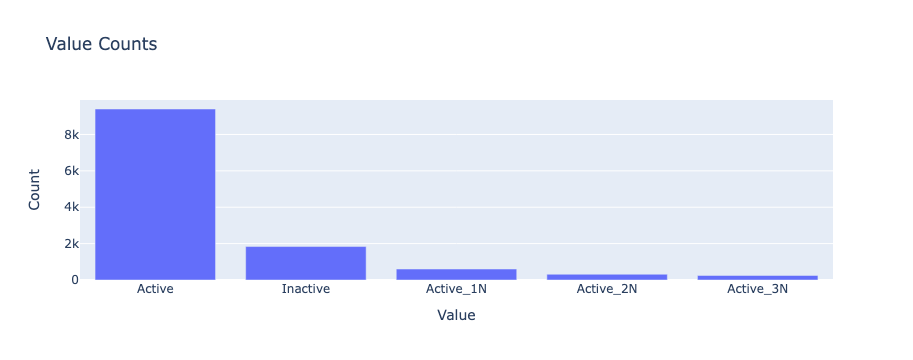

In [369]:
import plotly.graph_objects as go

# Define the labels and counts
labels = ['Active', 'Inactive', 'Active_1N', 'Active_2N', 'Active_3N']
counts = [9401, 1839, 603, 316, 249]

# Create the bar plot
fig = go.Figure(data=[go.Bar(x=labels, y=counts)])

# Customize the layout
fig.update_layout(
    title='Value Counts',
    xaxis_title='Value',
    yaxis_title='Count'
)

# Show the plot
fig.show()


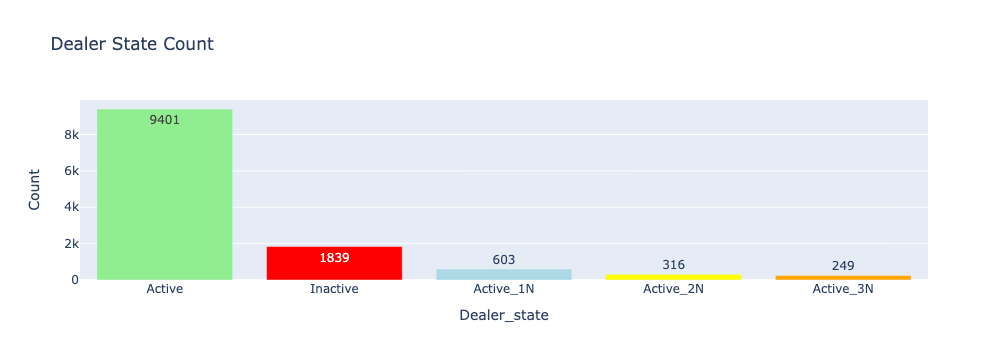

In [426]:
labels = ['Active', 'Inactive', 'Active_1N', 'Active_2N', 'Active_3N']
counts = [9401, 1839, 603, 316, 249]

# Define the colors for each bar
colors = ['lightgreen','red', 'lightblue', 'yellow', 'orange']

# Create the bar plot
fig = go.Figure(data=[go.Bar(x=labels, y=counts, marker_color=colors, text=counts, textposition='auto')])

# Customize the layout
fig.update_layout(
    title='Dealer State Count',
    xaxis_title='Dealer_state',
    yaxis_title='Count'
)

# Show the plot
fig.show()

### Analyzing the churned dealers

In [278]:
churn_dealer

,1,2,3,4,5,6,7,8,9,10,...,63,64,65,66,67,68,69,70,71,Month_new_user
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000001,-,-,-,Active,Active,Active_1N,Active,Active,Active,Active_1N,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,3
7000002,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,0
7000011,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,0
7000019,Active,Active,Active,Active,Active,Active,Active,Active,Active,Active,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,Churn,Churn,0
7000024,-,Active,Active,Active,Active,Active,Active,Active_1N,Active,Active_1N,...,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,Churn,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035529,-,-,-,-,-,-,-,-,-,-,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,Churn,56
7035569,-,-,-,-,-,-,-,-,-,-,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,57
7035583,-,-,-,-,-,-,-,-,-,-,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,57


In [370]:
joined_df = pd.concat([pivot_copy , churn_dealer], axis=1)

In [371]:
joined_df=joined_df.dropna()
joined_df

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,15,16,17,18,19,20,21,22,23,Month_new_user
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,Churn,Churn,0.0
7000043,103.0,74.0,130.5,60.5,97.0,23.5,41.5,1.0,0.0,0.0,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,Churn,Churn,0.0
7000048,44.0,52.0,33.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Inactive,Inactive,Churn,Churn,Churn,Churn,Churn,Churn,Churn,0.0
7000063,0.0,20.0,12.0,29.0,7.0,41.0,12.0,0.0,0.0,0.0,...,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,Churn,Churn,Churn,1.0
7000079,30.0,110.0,30.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Inactive,Inactive,Churn,Churn,Churn,Churn,Churn,Churn,Churn,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,Churn,8.0
7035569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.5,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,9.0
7035583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Churn,9.0


In [374]:
cols = [
 '2021-04',
 '2021-05',
 '2021-06',
 '2021-07',
 '2021-08',
 '2021-09',
 '2021-10',
 '2021-11',
 '2021-12',
 '2022-01',
 '2022-02',
 '2022-03',
 '2022-04',
 '2022-05',
 '2022-06',
 '2022-07',
 '2022-08',
 '2022-09',
 '2022-10',
 '2022-11',
 '2022-12',
 '2023-01',
 '2023-02']

churn_df = joined_df[cols]
churn_df

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000019,12.0,50.0,133.0,104.0,165.0,123.5,0.0,7.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000043,103.0,74.0,130.5,60.5,97.0,23.5,41.5,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000048,44.0,52.0,33.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000063,0.0,20.0,12.0,29.0,7.0,41.0,12.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7000079,30.0,110.0,30.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7035569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7035583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


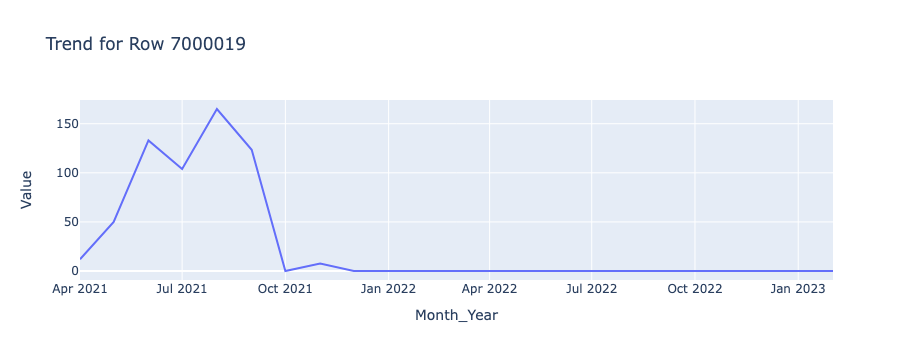

Dropdown(description='Select Row:', options=(7000019, 7000043, 7000048, 7000063, 7000079, 7000117, 7000123, 70…

In [375]:
#%matplotlib widget
import plotly.express as px
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display

# Assuming your DataFrame is named 'df'


# Create a dropdown widget with row numbers
dropdown = widgets.Dropdown(
    options=churn_df.index,
    description='Select Row:'
)

# Define the function to update the plot when the dropdown value changes
def on_dropdown_change(change):
    row = change.new
    plot_trend(row)

dropdown.observe(on_dropdown_change, names='value')

# Define the plot function
def plot_trend(row):
    row_data = churn_df.loc[row]
    data = {'Month_Year': row_data.index, 'Value': row_data.values}
    fig = px.line(data, x='Month_Year', y='Value', title=f'Trend for Row {row}')
    fig.show()

# Initial plot with the first row
plot_trend(churn_df.index[0])


# Display the dropdown widget
display(dropdown)

In [302]:
churn_df.loc[7000001,].values

array([ 0.,  0.,  0., 20., 20.,  0., 20., 10., 26.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.])

# Determining YOY and QOQ columns


In [376]:
df_sales_new

,Sales Region,Sales Zone,Sales Type,Sold To Party Code,Sold To Party District Name,Ship to Party Code,Ship to Party District,Brand,Product,Bill Quantity,date,Month_Year,Year,Quarter
0,South,Goa,Trade,7031240,North Goa,77074837,NORTH GOA,DALMIA,OPC,13.0,2021-07-01,2021-07,2021,2021Q3
1,South,Goa,Trade,7015228,South Goa,88005773,NORTH GOA,DALMIA,PPC,13.0,2021-07-03,2021-07,2021,2021Q3
2,South,Goa,Trade,7015228,South Goa,77073771,NORTH GOA,DALMIA,PPC,26.0,2021-07-03,2021-07,2021,2021Q3
3,South,Goa,Trade,7031479,South Goa,7031479,SOUTH GOA,DALMIA,PPC,13.0,2021-07-06,2021-07,2021,2021Q3
4,South,Goa,Trade,7031240,North Goa,88018025,SOUTH GOA,DALMIA,PPC,13.0,2021-07-06,2021-07,2021,2021Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190497,West,MH (W),Trade,7036014,Jalgaon,7036014,JALGAON,DALMIA,PPC,7.5,2022-07-31,2022-07,2022,2022Q3
190498,West,MH (W),Trade,7036014,Jalgaon,7036014,JALGAON,DALMIA,PPC,0.0,2022-07-31,2022-07,2022,2022Q3
190499,West,MH (W),Trade,7036014,Jalgaon,7036014,JALGAON,DALMIA,PPC,0.0,2022-07-31,2022-07,2022,2022Q3
190500,West,MH (W),Trade,7036014,Jalgaon,7036014,JALGAON,DALMIA,PPC,0.0,2022-07-31,2022-07,2022,2022Q3


In [774]:
df_sales_new.to_csv('sales_data.csv')

In [534]:
df_group_QOQ = df_sales_new[['Sold To Party Code','Month_Year','Quarter',
                     'Bill Quantity']].groupby(['Sold To Party Code',
                                                'Quarter','Month_Year']).agg({'Bill Quantity': ['sum']}).reset_index()

In [535]:
df_group_QOQ.columns = ['Sold To Party Code','Quarter','Month_Year','sum']
df_group_QOQ = df_group_QOQ[ ['Sold To Party Code','Quarter','sum']].groupby(['Sold To Party Code',
                                                'Quarter']).agg({'sum':['mean']}).reset_index()
df_group_QOQ

,Sold To Party Code,Quarter,sum
,,,mean
0,7000004,2021Q2,182.500000
1,7000004,2021Q3,83.333333
2,7000004,2021Q4,48.000000
3,7000004,2022Q1,52.000000
4,7000004,2022Q2,80.000000
...,...,...,...
76466,7039320,2023Q1,20.000000
76467,7039324,2023Q1,25.000000
76468,7039325,2023Q1,15.000000


In [677]:
df_group_QOQ.columns = ['Sold To Party Code','Quarter','mean']
pivot_table_QOQ = pd.pivot_table(df_group_QOQ, values='mean',
                       columns='Quarter', index = 'Sold To Party Code' )

In [824]:
pivot_table_QOQ

Quarter,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4,2023Q1
Sold To Party Code,,,,,,,,
7000004,182.5,83.333333,48.000000,52.000000,80.0,27.333333,54.166667,82.50
7000010,47.0,27.000000,30.000000,24.500000,21.0,28.900000,0.000000,0.00
7000015,39.0,73.833333,65.833333,43.333333,62.5,65.333333,50.500000,0.00
7000019,65.0,130.833333,7.500000,0.000000,0.0,0.000000,0.000000,0.00
7000022,0.0,0.000000,0.000000,0.000000,2.5,20.000000,16.000000,24.00
...,...,...,...,...,...,...,...,...
7039320,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,20.00
7039324,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,25.00
7039325,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,15.00


In [825]:
pivot_table_QOQ = pivot_table_QOQ.fillna(0)
df_qoq = pd.DataFrame()
columns = pivot_table_QOQ.columns
for i in range(1, len(columns)):
    current_month = columns[i]
    previous_month = columns[i-1]
    df_qoq[f'{current_month}_QOQ'] = ((pivot_table_QOQ[current_month] - pivot_table_QOQ[previous_month])/pivot_table_QOQ[previous_month])*100

In [826]:
df_qoq = df_qoq.fillna(0)
df_qoq = df_qoq.replace(np.inf, 999)

In [827]:
df_qoq['2022Q2_QOQ'].min()

-100.0

In [828]:
df_qoq_year_wise = pd.DataFrame()
columns = pivot_table_QOQ.columns
for i in range(4, len(columns)):
    current_month = columns[i]
    previous_month = columns[i-4]
    #quarter_of_previous_month = columns[i-1:i+2].to_list()
    #df_qoq_year_wise[f'{current_month}_QOQ_yoy'] = pivot_table_QOQ[current_month] - pivot_table_QOQ[previous_month]
     
    df_qoq_year_wise[f'{current_month}_QOQ_yoy'] = ((pivot_table_QOQ[current_month] - pivot_table_QOQ[previous_month])/pivot_table_QOQ[previous_month])*100

In [829]:
df_qoq_year_wise= df_qoq_year_wise.fillna(0)
df_qoq_year_wise = df_qoq_year_wise.replace(np.inf, 999)

In [830]:
df_qoq_year_wise

,2022Q2_QOQ_yoy,2022Q3_QOQ_yoy,2022Q4_QOQ_yoy,2023Q1_QOQ_yoy
Sold To Party Code,,,,
7000004,-56.164384,-67.200000,12.847222,58.653846
7000010,-55.319149,7.037037,-100.000000,-100.000000
7000015,60.256410,-11.512415,-23.291139,-100.000000
7000019,-100.000000,-100.000000,-100.000000,0.000000
7000022,999.000000,999.000000,999.000000,999.000000
...,...,...,...,...
7039320,0.000000,0.000000,0.000000,999.000000
7039324,0.000000,0.000000,0.000000,999.000000
7039325,0.000000,0.000000,0.000000,999.000000


In [831]:
df_analyze = pd.concat([df_qoq , df_qoq_year_wise ] , axis = 1)

In [838]:
df_analyze.to_csv('Dealers_qoq_yoy_analysis.csv')

In [832]:
df_a = df_analyze[['2022Q4_QOQ_yoy','2022Q4_QOQ']]
#df_a[(abs(df_a['2022Q2_QOQ_yoy'])>10)&(df_a['2022Q2_QOQ']<0)]

In [833]:
df_a

,2022Q4_QOQ_yoy,2022Q4_QOQ
Sold To Party Code,,
7000004,12.847222,98.170732
7000010,-100.000000,-100.000000
7000015,-23.291139,-22.704082
7000019,-100.000000,0.000000
7000022,999.000000,-20.000000
...,...,...
7039320,0.000000,0.000000
7039324,0.000000,0.000000
7039325,0.000000,0.000000


In [834]:
def analyze_trend(df): 
    df = df.applymap(lambda x: 0 if -10 <= x <= 10 else x)
    analysis_matrix = pd.DataFrame(columns = ['qoq_+','qoq_0','qoq_-'] , index = ['yoy_+','yoy_0','yoy_-'])
    analysis_matrix.loc['yoy_+','qoq_+'] = df[(df[df.columns[0]]>0)&(df[df.columns[1]]>0)].shape[0]
    analysis_matrix.loc['yoy_+','qoq_0'] = df[(df[df.columns[0]]>0)&(df[df.columns[1]]==0)].shape[0]
    analysis_matrix.loc['yoy_+','qoq_-'] = df[(df[df.columns[0]]>0)&(df[df.columns[1]]<0)].shape[0]
    analysis_matrix.loc['yoy_0','qoq_+'] = df[(df[df.columns[0]]==0)&(df[df.columns[1]]>0)].shape[0]
    analysis_matrix.loc['yoy_0','qoq_0'] = df[(df[df.columns[0]]==0)&(df[df.columns[1]]==0)].shape[0]
    analysis_matrix.loc['yoy_0','qoq_-'] = df[(df[df.columns[0]]==0)&(df[df.columns[1]]<0)].shape[0]
    analysis_matrix.loc['yoy_-','qoq_+'] = df[(df[df.columns[0]]<0)&(df[df.columns[1]]>0)].shape[0]
    analysis_matrix.loc['yoy_-','qoq_0'] = df[(df[df.columns[0]]<0)&(df[df.columns[1]]==0)].shape[0]
    analysis_matrix.loc['yoy_-','qoq_-'] = df[(df[df.columns[0]]<0)&(df[df.columns[1]]<0)].shape[0]
    return analysis_matrix

In [835]:
analysis_matrix = analyze_trend(df_a)

In [836]:
analysis_matrix

,qoq_+,qoq_0,qoq_-
yoy_+,1885,744,2886
yoy_0,192,2428,1025
yoy_-,470,1787,2774


In [485]:
df_1 = pd.concat([pivot_table,active_dealer], axis = 1)

In [486]:
df_1 = df_1.dropna()
df_filled = df_1.iloc[:,0:23].copy()

In [809]:
df_filled

,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,...,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02
Sold To Party Code,,,,,,,,,,,,,,,,,,,,,
7000004,255.5,85.0,207.0,102.0,73.5,74.5,43.0,25.0,76.0,53.0,...,114.0,35.0,22.0,40.0,20.0,20.0,20.0,122.5,75.0,90.00
7000010,57.0,37.0,0.0,24.0,30.0,0.0,41.0,24.0,25.0,24.0,...,17.0,0.0,33.8,24.0,0.0,0.0,0.0,0.0,0.0,0.00
7000015,4.0,50.0,63.0,62.0,91.0,68.5,70.5,77.0,50.0,44.5,...,75.5,85.0,42.0,109.0,45.0,74.0,27.0,0.0,0.0,0.00
7000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.5,1.5,12.0,24.0,24.0,22.0,5.0,21.0,24.0,0.00
7000025,98.0,108.5,87.0,105.0,107.5,102.0,107.0,117.0,60.0,85.0,...,100.0,136.0,175.0,150.0,95.0,48.0,108.8,73.0,167.0,137.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.00
7039324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.00
7039325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.00


In [813]:
active_dealer.to_csv('data/active_df.csv')

In [814]:
df_filled.to_csv('data/filled_df.csv')

In [498]:
#df_filled = df.fillna(0)

# Calculate YoY difference for each month
df_yoy = pd.DataFrame()
columns = df_filled.columns
for i in range(12, len(columns)):
    current_month = columns[i]
    previous_month = columns[i-12]
    #quarter_of_previous_month = columns[i-1:i+2].to_list()
    df_yoy[f'{current_month}_YoY'] = df_filled[current_month] - df_filled[previous_month]

In [499]:
df_yoy

,2022-04_YoY,2022-05_YoY,2022-06_YoY,2022-07_YoY,2022-08_YoY,2022-09_YoY,2022-10_YoY,2022-11_YoY,2022-12_YoY,2023-01_YoY,2023-02_YoY
Sold To Party Code,,,,,,,,,,,
7000004,-164.5,29.0,-172.0,-80.0,-33.5,-54.5,-23.0,-5.0,46.5,22.0,28.00
7000010,-32.0,-20.0,0.0,9.8,-6.0,0.0,-41.0,-24.0,-25.0,-24.0,-25.00
7000015,23.0,25.5,22.0,-20.0,18.0,-23.5,3.5,-50.0,-50.0,-44.5,-15.00
7000022,0.0,3.5,1.5,12.0,24.0,24.0,22.0,5.0,21.0,24.0,0.00
7000025,-38.0,-8.5,49.0,70.0,42.5,-7.0,-59.0,-8.2,13.0,82.0,83.00
...,...,...,...,...,...,...,...,...,...,...,...
7039320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.00
7039324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.00
7039325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.00


In [503]:
pivot_table_QOQ = pivot_table_QOQ.fillna(0)

Quarter,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4,2023Q1
Sold To Party Code,,,,,,,,
7000004,182.500000,83.333333,48.000000,52.000000,80.000000,27.333333,54.166667,55.000000
7000010,31.333333,18.000000,30.000000,16.333333,14.000000,19.266667,0.000000,0.000000
7000015,39.000000,73.833333,65.833333,43.333333,62.500000,65.333333,33.666667,0.000000
7000019,65.000000,130.833333,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000
7000022,0.000000,0.000000,0.000000,0.000000,1.666667,20.000000,16.000000,8.000000
...,...,...,...,...,...,...,...,...
7039320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.666667
7039324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.333333
7039325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000


## Reason for non billing for dealers

In [592]:
non_billing = pd.read_excel('data/non_billing_reason_data.xlsb',  engine='pyxlsb' )

In [593]:
non_billing.shape

(388059, 5)

In [594]:
non_billing.head()

,salesofficer_id,party_code,dap_id,last_reason_date,reason_desc
0,EMP1010544,7032911,97597,44287,Debtors - Dealer awaiting payments from his cu...
1,EMP0008416,7031439,33943,44287,Inventory - Dealer has stock
2,EMP0010076,77009162,3682,44287,Poor sell out on low demand for Dalmia brand
3,EMP1027004,77058389,19642,44287,Converted to sub dealer Ã¢â‚¬â€œ buy from whol...
4,EMP0010234,77072126,81811,44287,Debtors - Dealer awaiting payments from his cu...


In [595]:
non_billing['party_code'] = pd.to_numeric(non_billing['party_code'], errors='coerce')

In [596]:
non_billing = non_billing[~non_billing['party_code'].isnull()]
non_billing['party_code'] = non_billing['party_code'].astype(int)

In [597]:
non_billing = non_billing[(non_billing['party_code']>=7000000)&(non_billing['party_code']<7100000)]

In [598]:
non_billing.shape

(117697, 5)

In [599]:
from utility.datetime_util import timeseries_conversion
non_billing['last_reason_date'] = non_billing['last_reason_date'].apply(timeseries_conversion)

In [601]:
non_billing = non_billing.sort_values(by = 'party_code')

In [602]:
non_billing

,salesofficer_id,party_code,dap_id,last_reason_date,reason_desc
313010,EMP1031614,7000004,2567,2022-10-19,Personal Reason to Dealer
284526,EMP1031614,7000004,2567,2022-08-26,Inventory - Dealer has stock
88442,EMP1026319,7000006,4509,2021-09-13,Current pricing issue - Net Billing of many Br...
122801,EMP1026319,7000006,4509,2021-11-22,Current pricing issue - Net Billing of many Br...
71010,EMP1026319,7000006,4509,2021-08-10,Current pricing issue - Net Billing of many Br...
...,...,...,...,...,...
40555,EMP0010287,7048123,34394,2021-06-16,Personal Reason to Dealer
116955,EMP0010287,7048123,34394,2021-11-11,Personal Reason to Dealer
333850,EMP1039181,7048123,34394,2022-12-08,Personal Reason to Dealer
192284,EMP0008106,7086359,126429,2022-03-22,Inventory - Dealer has stock


In [609]:
personal_reason = non_billing[non_billing['reason_desc']=='Personal Reason to Dealer'].copy()
personal_reason.shape

(55371, 5)

In [610]:
personal_reason

,salesofficer_id,party_code,dap_id,last_reason_date,reason_desc
313010,EMP1031614,7000004,2567,2022-10-19,Personal Reason to Dealer
51997,EMP1025593,7000010,878,2021-07-06,Personal Reason to Dealer
308562,EMP1010516,7000010,878,2022-10-10,Personal Reason to Dealer
316835,EMP1010516,7000010,878,2022-10-28,Personal Reason to Dealer
43870,EMP1025593,7000010,878,2021-06-22,Personal Reason to Dealer
...,...,...,...,...,...
21440,EMP0010287,7048123,34394,2021-05-21,Personal Reason to Dealer
80039,EMP0010287,7048123,34394,2021-08-26,Personal Reason to Dealer
40555,EMP0010287,7048123,34394,2021-06-16,Personal Reason to Dealer
116955,EMP0010287,7048123,34394,2021-11-11,Personal Reason to Dealer


In [649]:
def create_date_columns(df_list):#pass the dataframe in the list format 
    new_df = pd.DataFrame()
    for i in df_list:
        i['date'] = pd.to_datetime(i['last_reason_date'])
        i['Month_Year'] = pd.to_datetime(i['date']).dt.strftime('%Y-%m')
        i['Year'] = pd.to_datetime(i['date']).dt.year
        i['Quarter'] = i['date'].dt.to_period('Q')
        new_df = pd.concat([new_df,i], axis=0)

    return new_df

non_billing = create_date_columns([non_billing])

In [650]:
non_billing.drop(['last_reason_date','date','Year'] , axis =1 , inplace = True)

In [651]:
non_billing= non_billing[non_billing['Month_Year']<'2023-03']

In [639]:
pivot_copy.columns

Index(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02'],
      dtype='object', name='Month Year')

In [640]:
result_matrix_copy = result_matrix.copy()
result_matrix_copy.drop('Month_new_user', axis =1 , inplace = True)

In [641]:
result_matrix_copy.columns = pivot_copy.columns

In [654]:
index_list = list(non_billing['party_code'])
date_list = list(non_billing['Month_Year'])
activity_list = []
for i in range(non_billing.shape[0]):
    index = index_list[i]
    date = date_list[i]
    if index in result_matrix_copy.index:
        activity = result_matrix_copy.loc[index , date]
        activity_list.append(activity)
    else:
        activity_list.append(np.NaN)
    
   
    

In [655]:
non_billing['Activity'] = activity_list

In [656]:
non_billing

,salesofficer_id,party_code,dap_id,reason_desc,Month_Year,Quarter,Activity
313010,EMP1031614,7000004,2567,Personal Reason to Dealer,2022-10,2022Q4,Active
284526,EMP1031614,7000004,2567,Inventory - Dealer has stock,2022-08,2022Q3,Active
88442,EMP1026319,7000006,4509,Current pricing issue - Net Billing of many Br...,2021-09,2021Q3,NaN
122801,EMP1026319,7000006,4509,Current pricing issue - Net Billing of many Br...,2021-11,2021Q4,NaN
71010,EMP1026319,7000006,4509,Current pricing issue - Net Billing of many Br...,2021-08,2021Q3,NaN
...,...,...,...,...,...,...,...
40555,EMP0010287,7048123,34394,Personal Reason to Dealer,2021-06,2021Q2,NaN
116955,EMP0010287,7048123,34394,Personal Reason to Dealer,2021-11,2021Q4,NaN
333850,EMP1039181,7048123,34394,Personal Reason to Dealer,2022-12,2022Q4,NaN
192284,EMP0008106,7086359,126429,Inventory - Dealer has stock,2022-03,2022Q1,NaN


In [823]:
non_billing[non_billing['Activity'].isna()==False]

,salesofficer_id,party_code,dap_id,reason_desc,Month_Year,Quarter,Activity
313010,EMP1031614,7000004,2567,Personal Reason to Dealer,2022-10,2022Q4,Active
284526,EMP1031614,7000004,2567,Inventory - Dealer has stock,2022-08,2022Q3,Active
323569,EMP1010516,7000010,878,Creditor - Credit limit exhausted with Dalmia,2022-11,2022Q4,Active_3N
51997,EMP1025593,7000010,878,Personal Reason to Dealer,2021-07,2021Q3,Active
340272,EMP1031778,7000010,878,Un-resolved issues with company,2022-12,2022Q4,Inactive
...,...,...,...,...,...,...,...
356707,EMP0000136,7039233,153165,Converted to sub dealer Ã¢â‚¬â€œ buy from whol...,2023-02,2023Q1,Active
359369,EMP0008140,7039234,152668,Poor sell out on low demand for Dalmia brand,2023-02,2023Q1,Active
357668,EMP1032828,7039236,75549,Personal Reason to Dealer,2023-02,2023Q1,Active
359856,EMP1031946,7039244,153374,Personal Reason to Dealer,2023-02,2023Q1,Active


In [657]:
non_billing['Activity'].value_counts()

Inactive     22795
Active       18414
Active_2N    11299
Active_1N    10319
Active_3N     7225
Churn         3594
Name: Activity, dtype: int64

In [837]:
churn_activity = non_billing[non_billing['Activity']=='Churn']
churn_activity['reason_desc'].value_counts()

Personal Reason to Dealer                                                                                  1962
Inventory - Dealer has stock                                                                                368
Current pricing issue - Net Billing of many Brand vs Higher Billing, Higher Discount, Higher GST Impact     366
Poor sell out on low demand for Dalmia brand                                                                210
Not planning to continue with Dalmia                                                                        178
Converted to sub dealer Ã¢â‚¬â€œ buy from wholesaler                                                        143
Debtors - Dealer awaiting payments from his customers                                                       103
Creditor - Credit limit exhausted with Dalmia                                                                67
Awaiting pending discount settlement                                                                    

In [660]:
non_billing[non_billing['Activity']=='Active']['reason_desc'].value_counts()

Personal Reason to Dealer                                                                                  7519
Inventory - Dealer has stock                                                                               5038
Current pricing issue - Net Billing of many Brand vs Higher Billing, Higher Discount, Higher GST Impact    1640
Debtors - Dealer awaiting payments from his customers                                                      1166
Poor sell out on low demand for Dalmia brand                                                                779
Creditor - Credit limit exhausted with Dalmia                                                               727
Converted to sub dealer Ã¢â‚¬â€œ buy from wholesaler                                                        408
Awaiting pending discount settlement                                                                        386
Access to low price Non-trade material                                                                  

In [661]:
non_billing[non_billing['Activity']=='Active_1N']['reason_desc'].value_counts()

Personal Reason to Dealer                                                                                  4282
Inventory - Dealer has stock                                                                               2498
Current pricing issue - Net Billing of many Brand vs Higher Billing, Higher Discount, Higher GST Impact     831
Debtors - Dealer awaiting payments from his customers                                                       800
Creditor - Credit limit exhausted with Dalmia                                                               617
Poor sell out on low demand for Dalmia brand                                                                440
Converted to sub dealer Ã¢â‚¬â€œ buy from wholesaler                                                        208
Access to low price Non-trade material                                                                      180
Awaiting pending discount settlement                                                                    

In [662]:
non_billing[non_billing['Activity']=='Active_2N']['reason_desc'].value_counts()

Personal Reason to Dealer                                                                                  5198
Inventory - Dealer has stock                                                                               1920
Current pricing issue - Net Billing of many Brand vs Higher Billing, Higher Discount, Higher GST Impact     968
Debtors - Dealer awaiting payments from his customers                                                       783
Creditor - Credit limit exhausted with Dalmia                                                               735
Poor sell out on low demand for Dalmia brand                                                                515
Converted to sub dealer Ã¢â‚¬â€œ buy from wholesaler                                                        307
Not planning to continue with Dalmia                                                                        228
Access to low price Non-trade material                                                                  

In [663]:
non_billing[non_billing['Activity']=='Active_3N']['reason_desc'].value_counts()

Personal Reason to Dealer                                                                                  3607
Inventory - Dealer has stock                                                                                866
Current pricing issue - Net Billing of many Brand vs Higher Billing, Higher Discount, Higher GST Impact     674
Creditor - Credit limit exhausted with Dalmia                                                               435
Debtors - Dealer awaiting payments from his customers                                                       406
Poor sell out on low demand for Dalmia brand                                                                349
Not planning to continue with Dalmia                                                                        231
Converted to sub dealer Ã¢â‚¬â€œ buy from wholesaler                                                        212
Access to low price Non-trade material                                                                  

In [799]:
pivot_table_1 = pd.concat([pivot_copy , active_dealer], axis = 1)

In [803]:
pivot_table_1 = pivot_table_1.dropna()

In [805]:
pivot_table_1.columns

Index(['2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09',
       '2021-10', '2021-11', '2021-12', '2022-01', '2022-02', '2022-03',
       '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09',
       '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',
       '17', '18', '19', '20', '21', '22', '23', 'Month_new_user'],
      dtype='object')

In [807]:
test = pivot_table_1[['2022-10', '2022-11', '2022-12', '2023-01', '2023-02']].copy()
test

,2022-10,2022-11,2022-12,2023-01,2023-02
Sold To Party Code,,,,,
7000004,20.0,20.0,122.5,75.0,90.00
7000010,0.0,0.0,0.0,0.0,0.00
7000015,74.0,27.0,0.0,0.0,0.00
7000022,22.0,5.0,21.0,24.0,0.00
7000025,48.0,108.8,73.0,167.0,137.00
...,...,...,...,...,...
7039320,0.0,0.0,0.0,0.0,20.00
7039324,0.0,0.0,0.0,0.0,25.00
7039325,0.0,0.0,0.0,0.0,15.00


In [808]:
test.to_csv('dealer_wise_sales.csv')

In [816]:
styled_df.columns = pivot_table.columns

In [822]:
#styled_df